# Sensor data autocorrelation

Sensor are offline a lot, but that might be okay because there are often multiple sensors in a pretty small area. See how correlated sensors are with each other.

In [1]:
using Geodesy
using StatsBase
using Tables
using DataFrames
using DataFramesMeta
using CSV
using Dates
using Plots
using Statistics

In [2]:
include("../code/KFactors.jl")
using .KFactors

## First build the distance matrix

We want the distances between all sensors on the same freeway/direction.

In [3]:
distance_matrix = KFactors.get_distance_matrix("../data/sensor_meta_geo.csv")

,Fwy,Dir,from_sensor,to_sensor,distance
,Int64,String,Int64,Int64,Float64
1,58,W,158410,758410,0.0
2,58,W,158410,602594,398.041
3,58,W,158410,615851,595.408
4,58,W,158410,625829,891.251
5,58,W,158410,625832,1514.49
6,58,W,158410,602595,1527.3
7,58,W,158410,625828,1712.71
8,58,W,158410,602593,2026.68
9,58,W,158410,625833,2281.27


## Read in the sensor data

In [4]:
data = read_data("../data/all_district_peaks.parquet", "../data/sensor_meta_geo.csv", dropmissing=true)
nothing

┌ Info: Observations in each period
│   combine(groupby(data, :period), nrow) = 3×2 DataFrame
 Row │ period        nrow    
     │ Cat…          Int64   
─────┼───────────────────────
   1 │ pandemic       365083
   2 │ postpandemic   338894
   3 │ prepandemic   1371886
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:88
┌ Info: Before filtering, data has 2075863 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:99
┌ Info: After filtering, data has 971707 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:121


### Get rid of imputed data

We want correlations between real data.

In [5]:
data = data[.!ismissing.(data.peak_hour_occ) .& (data.periods_imputed .== 0), :]
nothing

In [6]:
transform!(groupby(data, :station), [:station, :date] => KFactors.find_nearest_values(distance_matrix, data, :peak_hour_occ) => :nearest_occ)

,station,peak_hour_occ,occ_entropy,total_occ,total_flow,station_type,freeway_number
,Int64?,Float64?,Float64?,Float64?,Int64?,String?,Int64?
1,312103,0.10535,5.38137,26.3512,108967,ML,50
2,312133,0.250706,5.21355,17.1021,39827,ML,5
3,312134,0.128285,5.48288,21.2293,37094,ML,5
4,312139,0.105051,5.42806,28.2015,129293,ML,50
5,312388,0.163371,5.41233,23.424,71572,ML,99
6,312422,0.177133,5.35322,21.7768,64657,ML,99
7,312525,0.0978797,5.4839,24.9347,81187,ML,99
8,312648,0.0745802,5.52186,20.4156,46295,ML,99
9,312689,0.143163,5.38956,9.5353,58536,ML,51


In [7]:
mean(ismissing.(data.nearest_occ))

0.003575724247377844

In [8]:
cor(data.peak_hour_occ, data.nearest_occ)

missing

In [9]:
complete = dropmissing(data, :nearest_occ)
@with complete cor(:peak_hour_occ, :nearest_occ)

0.6518134291100153

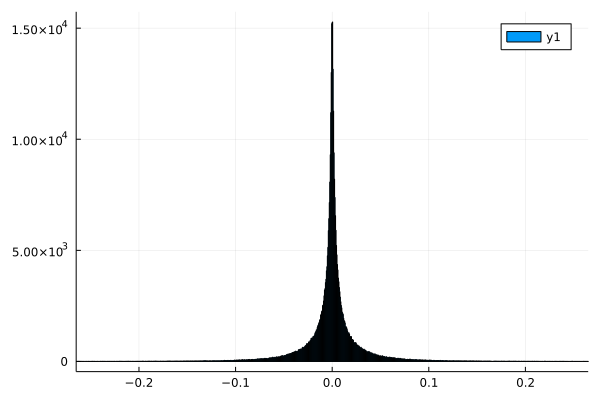

In [10]:
histogram(complete.peak_hour_occ - complete.nearest_occ, xlim=[-0.25, 0.25], semilogy=true)